In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === LOAD DATA ===
df = pd.read_excel('Dataset for ML.xlsx')
df.head()

,Jenjang Pendidikan,Program Studi,Minat dan Bakat,Jalur Pendaftaran PENS,Rata-rata Nilai Masuk PENS,Rencana Karir
0,D3,Teknik Telekomunikasi,"Fisika, Teknik Tenaga Listrik (TTL)",SBMPN (Seleksi Bersama Masuk Politeknik Negeri),474.0,Network Engineer
1,D3,Teknologi Multimedia Broadcasting,"Kimia, Teknologi Komputer Jaringan (TKJ)",SNMPN (Seleksi Nasional Masuk Politeknik Negeri),77.4,Broadcast Engineer
2,D4,Sains Data Terapan,"Pemrograman, Statistika, Teknologi Komputer Ja...",SNMPN (Seleksi Nasional Masuk Politeknik Negeri),631.0,Machine Learning Engineer
3,D4,Teknologi Game,"Teknik Instalasi Tenaga Listrik (TITL), Teknol...",SNMPTN / SNBP (Seleksi Nasional Berdasarkan Pr...,86.1,Game Designer
4,D4,Teknologi Rekayasa Multimedia,"Fisika, Matematika, Desain Animasi",SBMPTN/SNBT (Seleksi Nasional Berdasarkan Tes),86.5,Digital Content Creator


# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Jenjang Pendidikan          1000 non-null   object 
 1   Program Studi               1000 non-null   object 
 2   Minat dan Bakat             1000 non-null   object 
 3   Jalur Pendaftaran PENS      1000 non-null   object 
 4   Rata-rata Nilai Masuk PENS  1000 non-null   float64
 5   Rencana Karir               1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [4]:
# Distribusi jenjang pendidikan
print(df['Jenjang Pendidikan'].value_counts())

# Distribusi program studi
print(f"\n{df['Program Studi'].value_counts()}")

# Distribusi jalur pendaftaran
print(f"\n{df['Jalur Pendaftaran PENS'].value_counts()}")

# Distribusi rencana karir
print(f"\n{df['Rencana Karir'].value_counts()}")

Jenjang Pendidikan
D4    786
D3    214
Name: count, dtype: int64

Program Studi
Teknologi Game                       101
Teknik Elektro Industri               98
Sistem Pembangkit Energi              98
Teknologi Rekayasa Multimedia         90
Teknik Telekomunikasi                 87
Teknologi Rekayasa Internet           82
Teknik Informatika                    79
Teknologi Multimedia Broadcasting     77
Teknik Elektronika                    74
Teknik Mekatronika                    73
Teknik Komputer                       72
Sains Data Terapan                    69
Name: count, dtype: int64

Jalur Pendaftaran PENS
SNMPTN / SNBP (Seleksi Nasional Berdasarkan Prestasi)    272
SBMPTN/SNBT (Seleksi Nasional Berdasarkan Tes)           255
SBMPN (Seleksi Bersama Masuk Politeknik Negeri)          206
SNMPN (Seleksi Nasional Masuk Politeknik Negeri)         181
SIMANDIRI PENS                                            86
Name: count, dtype: int64

Rencana Karir
Automation Engineer             

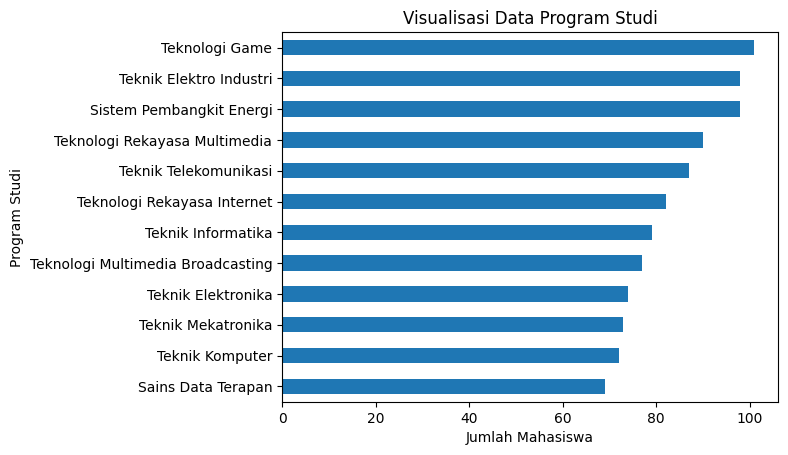

In [5]:
# Visualisai Data Program Studi
df['Program Studi'].value_counts().plot(kind='barh')
plt.title('Visualisasi Data Program Studi')
plt.xlabel('Jumlah Mahasiswa')
plt.gca().invert_yaxis()
plt.show()

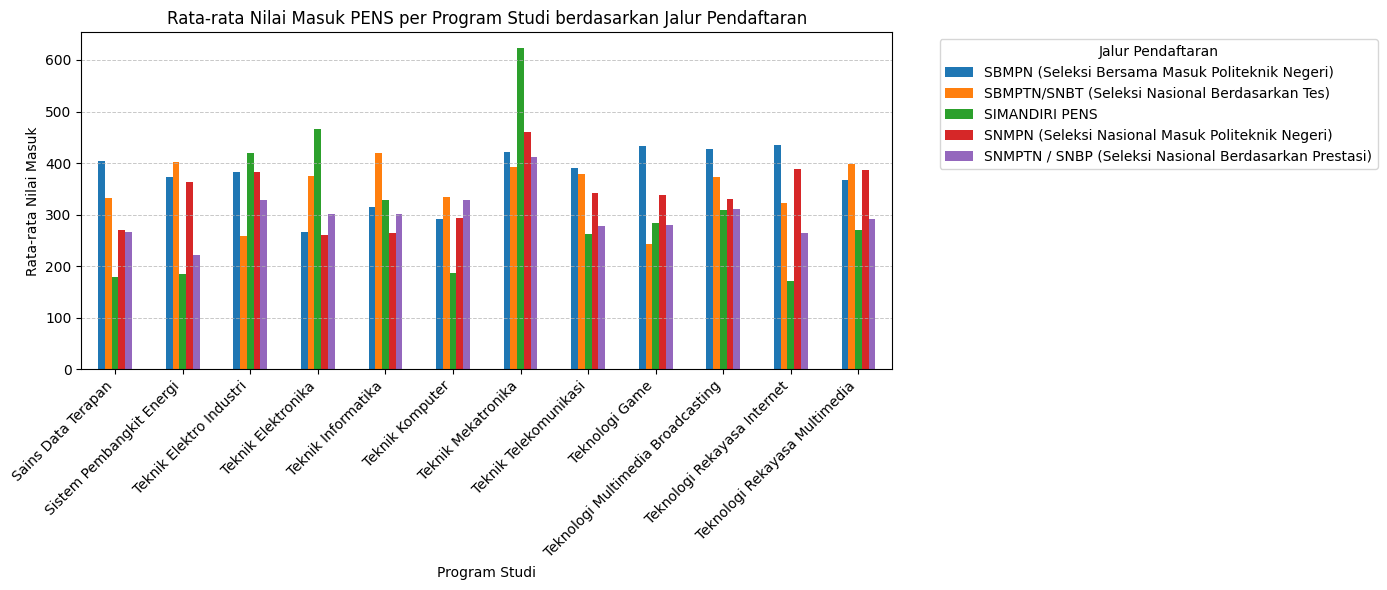

In [6]:
# Rata-rata nilai berdasarkan Jalur Masuk per Program Studi
# Buat pivot table
pivot_df = df.pivot_table(
    index='Program Studi',
    columns='Jalur Pendaftaran PENS',
    values='Rata-rata Nilai Masuk PENS',
    aggfunc='mean'
).fillna(0)

# Plot grouped bar chart
pivot_df.plot(kind='bar', figsize=(14, 6))
plt.title('Rata-rata Nilai Masuk PENS per Program Studi berdasarkan Jalur Pendaftaran')
plt.ylabel('Rata-rata Nilai Masuk')
plt.xlabel('Program Studi')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)  # Tambahkan garis bantu horizontal
plt.legend(title='Jalur Pendaftaran', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

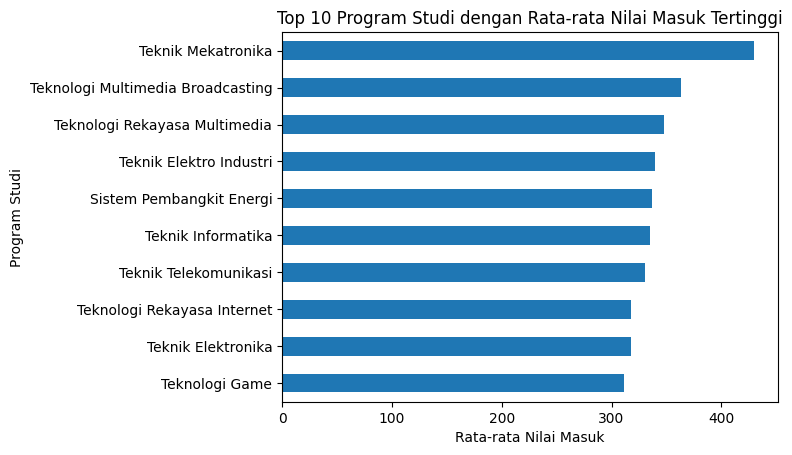

In [7]:
# Rata-rata nilai masuk per program studi (top 10)
mean_scores = df.groupby('Program Studi')['Rata-rata Nilai Masuk PENS'].mean().sort_values(ascending=False).head(10)
mean_scores.plot(kind='barh')
plt.title('Top 10 Program Studi dengan Rata-rata Nilai Masuk Tertinggi')
plt.xlabel('Rata-rata Nilai Masuk')
plt.gca().invert_yaxis()
plt.show()

# New Dataset

In [8]:
# Mapping Kolom Program Studi dan Jalur Seleksi
dataset_prev = df.copy()
program_studi_mapping = {
    "Teknik Elektronika": 1,
    "Teknik Telekomunikasi": 2,
    "Teknik Elektro Industri": 3,
    "Teknik Informatika": 4,
    "Teknik Mekatronika": 5,
    "Teknik Komputer": 6,
    "Teknologi Multimedia Broadcasting": 7,
    "Sistem Pembangkit Energi": 8,
    "Teknologi Game": 9,
    "Teknologi Rekayasa Internet": 10,
    "Teknologi Rekayasa Multimedia": 11,
    "Sains Data Terapan": 12
}
dataset_prev['Program Studi'] = dataset_prev['Program Studi'].map(program_studi_mapping)

jalur_mapping = {
    "SBMPN (Seleksi Bersama Masuk Politeknik Negeri)": "SBMPN",
    "SNMPN (Seleksi Nasional Masuk Politeknik Negeri)": "SNMPN",
    "SBMPTN/SNBT (Seleksi Nasional Berdasarkan Tes)": "SBMPTN/SNBT",
    "SNMPTN / SNBP (Seleksi Nasional Berdasarkan Prestasi)": "SNMPTN/SNBP",
    "SIMANDIRI PENS": "SIMANDIRI"
}
dataset_prev['Jalur Pendaftaran PENS'] = dataset_prev['Jalur Pendaftaran PENS'].replace(jalur_mapping)
dataset_prev.index += 1

# Simpan Dataset Baru
dataset_prev.to_csv("dataset_for_ml_fix.csv", index=True)

In [9]:
df = pd.read_csv('dataset_for_ml_fix.csv')
df.head()

,Unnamed: 0,Jenjang Pendidikan,Program Studi,Minat dan Bakat,Jalur Pendaftaran PENS,Rata-rata Nilai Masuk PENS,Rencana Karir
0,1,D3,2,"Fisika, Teknik Tenaga Listrik (TTL)",SBMPN,474.0,Network Engineer
1,2,D3,7,"Kimia, Teknologi Komputer Jaringan (TKJ)",SNMPN,77.4,Broadcast Engineer
2,3,D4,12,"Pemrograman, Statistika, Teknologi Komputer Ja...",SNMPN,631.0,Machine Learning Engineer
3,4,D4,9,"Teknik Instalasi Tenaga Listrik (TITL), Teknol...",SNMPTN/SNBP,86.1,Game Designer
4,5,D4,11,"Fisika, Matematika, Desain Animasi",SBMPTN/SNBT,86.5,Digital Content Creator


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1000 non-null   int64  
 1   Jenjang Pendidikan          1000 non-null   object 
 2   Program Studi               1000 non-null   int64  
 3   Minat dan Bakat             1000 non-null   object 
 4   Jalur Pendaftaran PENS      1000 non-null   object 
 5   Rata-rata Nilai Masuk PENS  1000 non-null   float64
 6   Rencana Karir               1000 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB


# Feature Engineering

In [12]:
# === OHE FITUR MINAT_BAKAT ===
minat_bakat_dummies = df['Minat dan Bakat'].str.get_dummies(sep=', ')
df = pd.concat([df, minat_bakat_dummies], axis=1)

# === DROP COLUMN ===
df = df.drop(columns=['Minat dan Bakat', 'Unnamed: 0'], axis=1)

# === SPLIT TRAIN-TEST DATA ===
X = df.drop('Program Studi', axis=1)
y = df['Program Studi']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=4824
)

# === IDENTIFIKASI FEATURES ===
numeric_features = ['Rata-rata Nilai Masuk PENS']
categorical_target = ['Jenjang Pendidikan', 'Jalur Pendaftaran PENS', 'Rencana Karir']

# === NORMALISASI ===
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# === ENCODING ===
target_transformer = Pipeline(steps=[
    ('target_enc', TargetEncoder())
])

# === PREPROCESSING ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('target', target_transformer, categorical_target)
    ],
    remainder='passthrough',  # fitur one-hot Minat dan Bakat tidak hilang
    sparse_threshold=0
)

In [13]:
# Transformasi X_train menggunakan preprocessor
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# Ambil nama kolom hasil transformasi:
# - Kolom numeric setelah scaling
transformed_cols = numeric_features.copy()

# - Kolom categorical yang di-encode
transformed_cols += [f"{col}_enc" for col in categorical_target]

# - Kolom yang di-passthrough (sisa kolom lain, termasuk one-hot Minat dan Bakat)
passthrough_cols = [col for col in X_train.columns if col not in numeric_features + categorical_target]
transformed_cols += passthrough_cols

# Buat dataframe dari hasil transformasi
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_cols, index=X_train.index)

# Tampilkan hasil transformasi
X_train_transformed_df.head()


,Rata-rata Nilai Masuk PENS,Jenjang Pendidikan_enc,Jalur Pendaftaran PENS_enc,Rencana Karir_enc,Desain Animasi,Desain Grafis,Elektronika,Fisika,Kimia,Matematika,Multimedia,Pemrograman,Statistika,Teknik Instalasi Tenaga Listrik (TITL),Teknik Tenaga Listrik (TTL),Teknologi Komputer Jaringan (TKJ)
708,0.988419,7.188300,6.818170,5.946138,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
476,1.051648,4.130723,6.244792,6.668812,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
813,0.601606,4.130723,6.756906,4.091290,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
146,-1.022264,7.188300,6.244792,5.797968,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
422,-0.967218,4.130723,6.756906,6.795732,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Baseline Model

In [14]:
# === MODEL DECISION TREE ===
baseline_pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

baseline_pipe_dt.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_dt.predict(X_train)
y_pred_test = baseline_pipe_dt.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Decision Tree Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Decision Tree Accuracy on Test Set : {test_acc:.4f}")


Baseline Decision Tree Accuracy on Train Set: 1.0000
Baseline Decision Tree Accuracy on Test Set : 0.9600


In [15]:
# === MODEL RANDOM FOREST ===
baseline_pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

baseline_pipe_rf.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_rf.predict(X_train)
y_pred_test = baseline_pipe_rf.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Random Forest Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Random Forest Accuracy on Test Set : {test_acc:.4f}")


Baseline Random Forest Accuracy on Train Set: 1.0000
Baseline Random Forest Accuracy on Test Set : 0.7667


In [16]:
# === MODEL EXTRA TREES ===
baseline_pipe_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

baseline_pipe_et.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI ===
y_pred_train = baseline_pipe_et.predict(X_train)
y_pred_test = baseline_pipe_et.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Baseline Extra Tree Accuracy on Train Set: {train_acc:.4f}")
print(f"Baseline Extra Tree Accuracy on Test Set : {test_acc:.4f}")


Baseline Extra Tree Accuracy on Train Set: 1.0000
Baseline Extra Tree Accuracy on Test Set : 0.6733


# Hyperparameter Tuning

In [17]:
# === DECISION TREE CLASSIFIER ===
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# === HYPERPARAMETER GRID ===
param_grid = {
    'classifier__criterion': ['entropy', 'gini'],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': [1.0, 'sqrt', 'log2'],
    'classifier__min_impurity_decrease': [0.0, 0.001],
    'classifier__splitter': ['best', 'random']
}

# === CROSS VALIDATION & GRID SEARCH ===
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"\nBest Hyperparameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Fitting 10 folds for each of 864 candidates, totalling 8640 fits

Best Hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 1.0, 'classifier__min_impurity_decrease': 0.001, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}
Best CV Accuracy: 0.9814


# Model Evaluation

In [18]:
# === EVALUASI DI TRAIN SET ===
y_pred_train = grid_search.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"Train Set Accuracy: {train_acc:.4f}")

# === EVALUASI DI TEST SET ===
y_pred_test = grid_search.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_acc:.4f}")

Train Set Accuracy: 0.9886
Test Set Accuracy: 0.9533


In [19]:
# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        26
           3       0.74      0.79      0.77        29
           4       1.00      1.00      1.00        24
           5       0.70      0.64      0.67        22
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        30
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        21

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



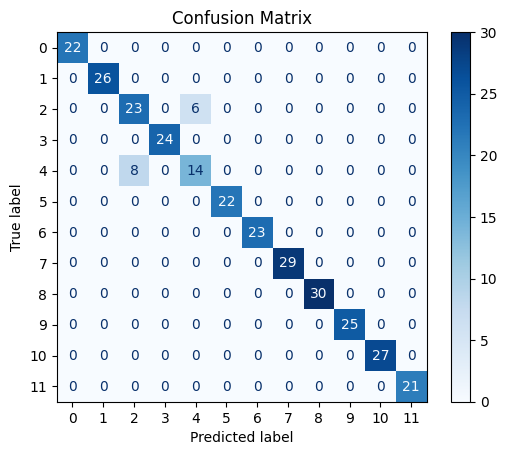

In [20]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

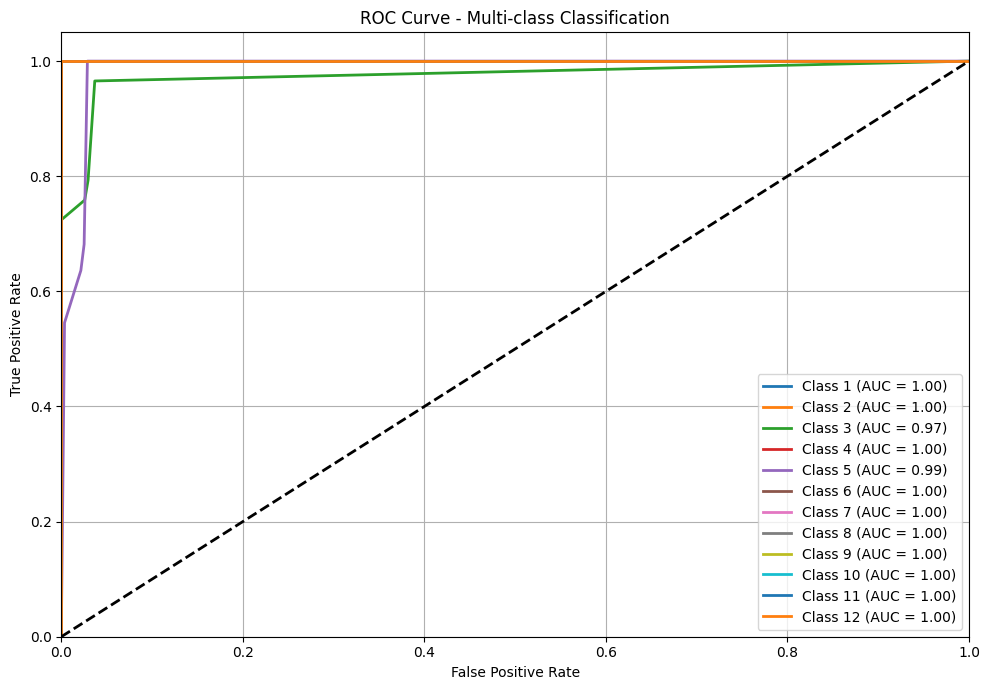

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# === ROC CURVE FOR MULTICLASS ===
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=grid_search.classes_)
y_score = grid_search.predict_proba(X_test)

n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {grid_search.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
best_model = grid_search.best_estimator_

def prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping):
    # Menyamakan kolom dataset dengan hasil training model
    minat_bakat_columns = [col for col in X_train.columns if col not in numeric_features + categorical_target]

    minat_bakat_dummies = data_baru['Minat dan Bakat'].str.get_dummies(sep=', ')
    for col in minat_bakat_columns:
        if col not in minat_bakat_dummies.columns:
            minat_bakat_dummies[col] = 0
    minat_bakat_dummies = minat_bakat_dummies[minat_bakat_columns]

    data_baru_processed = data_baru.drop('Minat dan Bakat', axis=1)
    data_baru_final = pd.concat([data_baru_processed, minat_bakat_dummies], axis=1)
    data_baru_final = data_baru_final[X_train.columns]

    # Prediksi data baru
    prediksi = best_model.predict(data_baru_final)[0]
    reverse_mapping = {v: k for k, v in program_studi_mapping.items()}

    print(f"Hasil Prediksi Program Studi (numerik): {prediksi}")
    print(f"Hasil Prediksi Program Studi: {reverse_mapping[prediksi]}")

    return reverse_mapping[prediksi]

In [23]:
data_baru = pd.DataFrame({
    'Jenjang Pendidikan': ['D3'],
    'Minat dan Bakat': ['Teknologi Informasi, Desain Animasi'],
    'Jalur Pendaftaran PENS': ['SNBP'],
    'Rencana Karir': ['Broadcast Engineer'],
    'Rata-rata Nilai Masuk PENS': [85.0]
})

hasil = prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping)


Hasil Prediksi Program Studi (numerik): 7
Hasil Prediksi Program Studi: Teknologi Multimedia Broadcasting


In [24]:
# Data baru dalam format DataFrame
data_baru = pd.DataFrame({
    'Jenjang Pendidikan': ['D3'],
    'Minat dan Bakat': ['Teknologi Informasi, Matematika'],
    'Jalur Pendaftaran PENS': ['SNBP'],
    'Rencana Karir': ['Business Intelligence Analyst'],
    'Rata-rata Nilai Masuk PENS': [85.0]
})

hasil = prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping)

Hasil Prediksi Program Studi (numerik): 12
Hasil Prediksi Program Studi: Sains Data Terapan


In [25]:
# Data baru dalam format DataFrame
data_baru = pd.DataFrame({
    'Jenjang Pendidikan': ['D3'],
    'Minat dan Bakat': ['Fisika, Matematika'],
    'Jalur Pendaftaran PENS': ['SNBP'],
    'Rencana Karir': ['Network Engineer'],
    'Rata-rata Nilai Masuk PENS': [85.0]
})

hasil = prediksi_program_studi(data_baru, best_model, X_train, numeric_features, categorical_target, program_studi_mapping)

Hasil Prediksi Program Studi (numerik): 2
Hasil Prediksi Program Studi: Teknik Telekomunikasi


In [26]:
import joblib

# Simpan pipeline model
joblib.dump(best_model, 'model.pkl')

# Simpan metadata penting
metadata = {
    'minat_bakat_columns': [col for col in X_train.columns if col not in numeric_features + categorical_target],
    'X_columns': X_train.columns.tolist(),
    'program_studi_mapping': program_studi_mapping,
    'reverse_mapping': {v: k for k, v in program_studi_mapping.items()}
}
joblib.dump(metadata, 'metadata.pkl')

['metadata.pkl']

In [27]:
import joblib
import pandas as pd

# Load model dan metadata
model = joblib.load('model.pkl')
metadata = joblib.load('metadata.pkl')

def prediksi_program_studi(data_baru):
    minat_bakat_columns = metadata['minat_bakat_columns']
    X_columns = metadata['X_columns']
    reverse_mapping = metadata['reverse_mapping']

    # Proses 'Minat dan Bakat'
    minat_bakat_dummies = data_baru['Minat dan Bakat'].str.get_dummies(sep=', ')
    for col in minat_bakat_columns:
        if col not in minat_bakat_dummies.columns:
            minat_bakat_dummies[col] = 0
    minat_bakat_dummies = minat_bakat_dummies[minat_bakat_columns]

    # Gabung dan urutkan kolom
    data_baru_processed = data_baru.drop('Minat dan Bakat', axis=1)
    data_baru_final = pd.concat([data_baru_processed, minat_bakat_dummies], axis=1)
    data_baru_final = data_baru_final[X_columns]

    # Prediksi
    prediksi = model.predict(data_baru_final)[0]
    return reverse_mapping[prediksi]


In [28]:
data_baru = pd.DataFrame({
    'Jenjang Pendidikan': ['D3'],
    'Minat dan Bakat': ['Teknologi Informasi, Desain Animasi'],
    'Jalur Pendaftaran PENS': ['SNBP'],
    'Rencana Karir': ['Broadcast Engineer'],
    'Rata-rata Nilai Masuk PENS': [85.0]
})

hasil = prediksi_program_studi(data_baru)
print("Program Studi:", hasil)


Program Studi: Teknologi Multimedia Broadcasting


In [10]:
import pandas as pd

# Baca data
data = pd.read_csv("dataset_for_ml_fix.csv")
minba_series = data["Rencana Karir"]

# Langkah: pisahkan berdasarkan koma dan kumpulkan semua ke satu list
all_minat_bakat = []
for item in minba_series.dropna():  # dropna jika ada NaN
    split_items = [x.strip() for x in item.split(',')]
    all_minat_bakat.extend(split_items)

# Ambil yang unik
unique_minat_bakat = sorted(set(all_minat_bakat))

# Tampilkan
print(unique_minat_bakat)


['3D Modeler', 'Automation Engineer', 'Broadcast Engineer', 'Business Intelligence Analyst', 'Cloud Engineer', 'Computer Engineer', 'Control Systems Engineer', 'Cybersecurity Analyst', 'Data Scientist', 'DevOps Engineer', 'Digital Content Creator', 'Electrical Engineer', 'Electronics Technician', 'Embedded Systems Engineer', 'Energy Analyst', 'Full Stack Developer', 'Game Designer', 'Game Developer', 'IT Support Specialist', 'Industrial Electrician', 'Machine Learning Engineer', 'Mechatronics Specialist', 'Motion Graphics Artist', 'Multimedia Designer', 'Network Engineer', 'Network Security Specialist', 'Power Plant Operator', 'RF Engineer', 'Renewable Energy Engineer', 'Robotics Engineer', 'Software Engineer', 'System Administrator', 'Telecommunications Specialist', 'UI/UX Designer', 'Video Editor']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

df = pd.read_csv('../pbl/dataset_for_ml_fix.csv')

# === OHE FITUR MINAT_BAKAT ===
minat_bakat_dummies = df['Minat dan Bakat'].str.get_dummies(sep=', ')
df = pd.concat([df, minat_bakat_dummies], axis=1)

# === Drop Kolom Tidak Diperlukan ===
df = df.drop(columns=['Minat dan Bakat', 'Unnamed: 0'], axis=1)

# === Split Train-Test ===
X = df.drop('Program Studi', axis=1)
y = df['Program Studi']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=4824
)

# === Identifikasi Fitur ===
numeric_features = ['Rata-rata Nilai Masuk PENS']
categorical_target = ['Jenjang Pendidikan', 'Jalur Pendaftaran PENS', 'Rencana Karir']

# === Preprocessing Pipelines ===
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
target_transformer = Pipeline(steps=[
    ('target_enc', TargetEncoder())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('target', target_transformer, categorical_target)
    ],
    remainder='passthrough',
    sparse_threshold=0
)

# === Buat Pipeline Model ===
baseline_pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === Mulai Tracking MLflow ===
mlflow.set_experiment("DecisionTree_ProgramStudi_Classification")

with mlflow.start_run():
    # Train model
    baseline_pipe_dt.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_dt.predict(X_train)
    y_pred_test = baseline_pipe_dt.predict(X_test)

    # Hitung akurasi
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging ke MLflow
    mlflow.set_tag("model_type", "DecisionTreeClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 4824)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")
    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Infer signature dan log model
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_dt,
        artifact_path="decision_tree_model",
        registered_model_name="DecisionTreeClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")


In [2]:
# === Pipeline Decision Tree dengan Hyperparameter Tuning ===
baseline_pipe_dt_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=10,
        max_features=1.0,
        min_impurity_decrease=0.001,
        min_samples_leaf=5,
        min_samples_split=2,
        splitter='best',
        random_state=42
    ))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === MLflow Tracking ===
mlflow.set_experiment("DecisionTree_ProgramStudi_Classification")

with mlflow.start_run():
    # Train model
    baseline_pipe_dt_tuned.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_dt_tuned.predict(X_train)
    y_pred_test = baseline_pipe_dt_tuned.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging
    clf = baseline_pipe_dt_tuned.named_steps['classifier']
    mlflow.set_tag("model_type", "DecisionTreeClassifier")
    mlflow.log_param("criterion", clf.criterion)
    mlflow.log_param("max_depth", clf.max_depth)
    mlflow.log_param("max_features", clf.max_features)
    mlflow.log_param("min_impurity_decrease", clf.min_impurity_decrease)
    mlflow.log_param("min_samples_leaf", clf.min_samples_leaf)
    mlflow.log_param("min_samples_split", clf.min_samples_split)
    mlflow.log_param("splitter", clf.splitter)
    mlflow.log_param("random_state", clf.random_state)

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model with schema
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_dt_tuned,
        artifact_path="decision_tree_model",
        registered_model_name="DecisionTreeClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (Tuned DT): {train_acc:.4f}")
    print(f"Test Accuracy  (Tuned DT): {test_acc:.4f}")

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'DecisionTreeClassifierProgramStudi' already exists. Creating a new version of this model...
2025/05/14 14:51:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifierProgramStudi, version 2
Created version '2' of model 'DecisionTreeClassifierProgramStudi'.


Train Accuracy (Tuned DT): 0.9886
Test Accuracy  (Tuned DT): 0.9533
🏃 View run nosy-rat-240 at: http://127.0.0.1:8080/#/experiments/541645843163475474/runs/975a1f0ed1eb4deaa69633acec11eab6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/541645843163475474


In [3]:
# === Pipeline Model Random Forest ===
baseline_pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# === MLflow Tracking untuk Random Forest ===
mlflow.set_experiment("RandomForest_ProgramStudi_Classification")

with mlflow.start_run():
    # Train
    baseline_pipe_rf.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_rf.predict(X_train)
    y_pred_test = baseline_pipe_rf.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging parameter & metric
    rf_model = baseline_pipe_rf.named_steps['classifier']
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", rf_model.n_estimators)
    mlflow.log_param("max_depth", rf_model.max_depth)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model + signature + input example
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_rf,
        artifact_path="random_forest_model",
        registered_model_name="RandomForestClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (RF): {train_acc:.4f}")
    print(f"Test Accuracy  (RF): {test_acc:.4f}")


2025/05/14 14:51:41 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest_ProgramStudi_Classification' does not exist. Creating a new experiment.
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'RandomForestClassifierProgramStudi'.
2025/05/14 14:51:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifierProgramStudi, version 1


Train Accuracy (RF): 1.0000
Test Accuracy  (RF): 0.7667
🏃 View run chill-roo-164 at: http://127.0.0.1:8080/#/experiments/652120192105627764/runs/1917ee33d935461ca86f7c1412dc6a2b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/652120192105627764


Created version '1' of model 'RandomForestClassifierProgramStudi'.


In [4]:
from sklearn.ensemble import ExtraTreesClassifier
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# === Pipeline Model Extra Trees ===
baseline_pipe_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

mlflow.set_tracking_uri("http://127.0.0.1:8080")

# === MLflow Tracking untuk Extra Trees ===
mlflow.set_experiment("ExtraTrees_ProgramStudi_Classification")

with mlflow.start_run():
    # Train
    baseline_pipe_et.fit(X_train, y_train)

    # Predict
    y_pred_train = baseline_pipe_et.predict(X_train)
    y_pred_test = baseline_pipe_et.predict(X_test)

    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Logging parameter & metric
    et_model = baseline_pipe_et.named_steps['classifier']
    mlflow.set_tag("model_type", "ExtraTreesClassifier")
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", et_model.n_estimators)
    mlflow.log_param("max_depth", et_model.max_depth)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("categorical_encoding", "TargetEncoder")

    mlflow.log_metric("train_accuracy", train_acc)
    mlflow.log_metric("test_accuracy", test_acc)

    # Log model + schema
    signature = infer_signature(X_train, y_pred_train)
    input_example = X_train.iloc[:5]

    mlflow.sklearn.log_model(
        sk_model=baseline_pipe_et,
        artifact_path="extra_trees_model",
        registered_model_name="ExtraTreesClassifierProgramStudi",
        signature=signature,
        input_example=input_example
    )

    print(f"Train Accuracy (Extra Trees): {train_acc:.4f}")
    print(f"Test Accuracy  (Extra Trees): {test_acc:.4f}")


2025/05/14 14:52:02 INFO mlflow.tracking.fluent: Experiment with name 'ExtraTrees_ProgramStudi_Classification' does not exist. Creating a new experiment.
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'ExtraTreesClassifierProgramStudi'.
2025/05/14 14:52:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ExtraTreesClassifierProgramStudi, version 1
Created version '1' of model 'ExtraTreesClassifierProgramStudi'.


Train Accuracy (Extra Trees): 1.0000
Test Accuracy  (Extra Trees): 0.6733
🏃 View run honorable-perch-574 at: http://127.0.0.1:8080/#/experiments/130978177454821492/runs/e3586698cb90447cbf92fc6d8f3fc884
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/130978177454821492
